# Combining Sampling Methods with Attractor Dynamics in Spiking Models of Head-Direction Systems
## by Vojko Pjanovic, Jacob Zavatone-Veth, Paul Masset, Sander Keemink & Michele Nardin. 

Code written by Vojko Pjanovic and Michele Nardin.

This notebook includes the code for Fig. 2 panels A and D.

# Panel A
### SCN Langevin Sampling with Multiplicative Synapses

Governing equations given by
$$\nabla_{\hat{x}} U(\hat{x}) = \sum^g_{d=1} d a_d (Dr)^{d-1}$$
$$\nabla_{\hat{x}} U(\hat{x}) = \sum^{g-1}_{d=0} A_d (Dr)^{\otimes d}$$
where $d a_d$ is absorbed into the $A_d$ term, and the coefficients are renamed/shifted.
Plugging this into the SCN 
$$
d\textbf{V} = \left[- \lambda \textbf{V} + \textbf{D}^T ( -\frac{1}{\tau_v} \sum^{g-1}_{d=0} A_d (Dr)^{\otimes d} + \lambda Dr) - \textbf{D}^T \textbf{Ds} \right] dt + \textbf{D}^T\sqrt{\frac{2}{\tau_v}} d\textbf{W}(t)
$$

simplifying gives
$$d\textbf{V} = \left[- \lambda \textbf{V} + \Omega_f \textbf{s} -\frac{1}{\tau_v} \sum^{g-1}_{d=0} \Omega_s^{md} r^{\otimes d} \right] dt + \textbf{D}^T\sqrt{\frac{2}{\tau_v}} d\textbf{W}(t)
$$
where
$$
\Omega_f = - D^TD
$$
$$\Omega_s^{m1} = D^T (A_1 - \lambda I)D$$
$$
\Omega_s^{md} = D^T A_d D^{\otimes d} \text{ for } d \in \{0,2,3,...,g-1\}
$$

### Example case for 4th order polynomial, with 3rd order gradient:

$$d\textbf{V} = \left[- \lambda \textbf{V} - D^TD \textbf{s} + \lambda D^T D r - \frac{1}{\tau_v}

 D^T \left[A_1 D r + A_2 D^{\otimes 2} r^{\otimes 2}+ A_3 D^{\otimes 3} r^{\otimes 3} \right]

\right] dt + \textbf{D}^T\sqrt{\frac{2 dt}{\tau_v}} d\textbf{W}(t) $$

In [3]:
import matplotlib.pyplot as plt
import numpy as np


a_0 = 0
a_1 = 1
a_2 = 1.3
a_3 = -3
a_4 = 1
a = np.array([a_0, a_1, a_2, a_3, a_4])

def func(x):
    return a_0 + a_1*x + a_2 * x**2 + a_3 * x**3 + a_4 * x**4
def score_func(x):
    return a_1 + 2*a_2 * x + 3* a_3 * x**2 + 4* a_4 * x**3

def ms_grad(r):
   return a[1] +  2 * a[2] * (D @ r) + 3 * a[3] * (np.kron(D,D) @ np.kron(r,r)) + 4 * a[4] * (np.kron(D,np.kron(D,D)) @ np.kron(r,np.kron(r,r)))

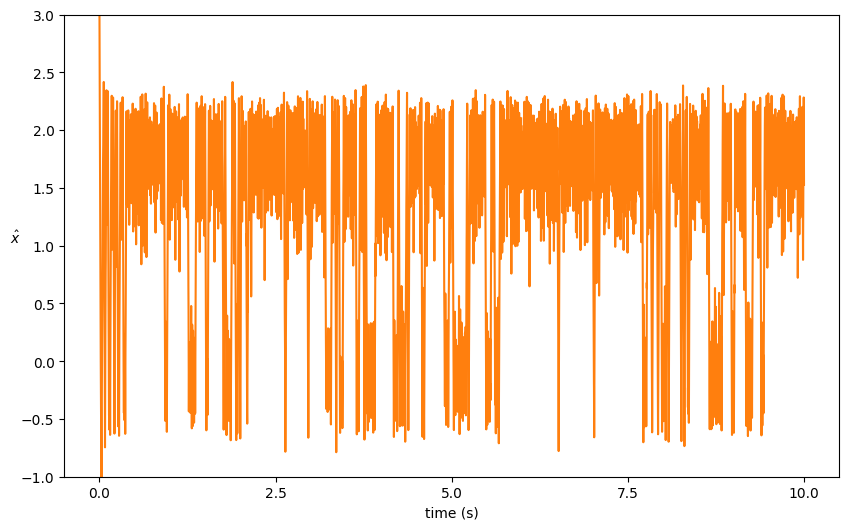

In [ ]:
np.random.seed(112)

# parameters
N = 10 # neurons
K = 1 # signal dimension
dt = 0.01 # time step
lam = 1

# length = 999
nt = 20000
length = nt-1

# initializations
D = np.random.randn(K,N)/10 # random decoder
T = np.diag(D.T@D)/2
O_f = D.T @ D
O_s = lam * D.T @ D

V = np.zeros([N,nt])
V[:,0] = 0.95*T 

s = np.zeros([N,nt])

r = np.zeros([N,nt])
# x_init = np.random.randn(K)
x_init = np.array([3])
r[:,0] = np.array(np.linalg.pinv(D) @ x_init) # initial rates

eps = 100

# simulation of dynamical system
for t in range(length-1):
    V[:,t+1] = V[:,t] + dt * (
        - lam * V[:,t]  
        - eps * D.T @ ms_grad(r[:,t]) 
        + O_s @ r[:,t] 
        - O_f @ s[:,t] ) + D.T @ (np.random.randn(K) * np.sqrt(2 * dt * eps))

    above = np.where(V[:,t+1] > T)[0]
    
    if len(above):
        s[above[np.random.randint(len(above))],t+1] = 1/dt
        # s[np.argmax(V[:,t+1]),t+1] = 1/dt
    
    r[:,t+1] = r[:,t] + dt*(s[:,t+1] - lam*r[:,t])

mscn_x_hat = (D@r[:,:length])[0]

plt.figure(figsize=(10,6))
plt.plot(mscn_x_hat, color='tab:orange', label = 'mscn Dr')
plt.xlabel('time (s)')
plt.xticks(np.linspace(0,20000,5),np.linspace(0,10,5))
plt.ylabel('$\hat{x}$', rotation = 0)
plt.ylim(-1,3)
plt.show()

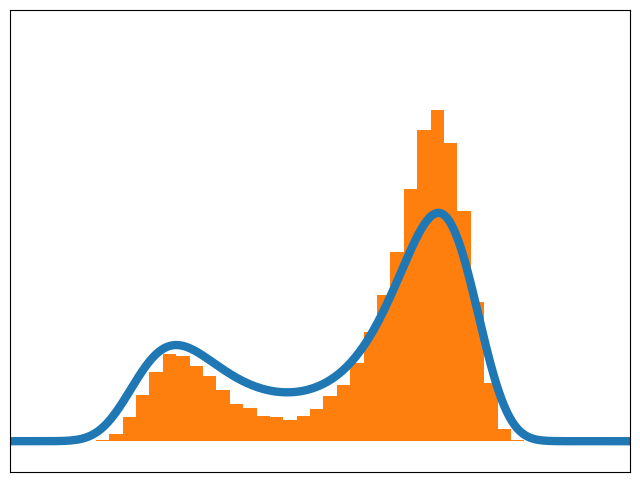

In [5]:

plt.figure(figsize=(8,6))
# plot real and sampled densities
plt.hist(mscn_x_hat,density=True,bins=40, color = 'tab:orange')
# plt.hist(x_hat,density=True,bins=100, alpha = 0.3, label = 'SCN sampled x')

x_vals = np.linspace(-5,5,1000)
# normalization constant
Z = np.sum(np.exp(-func(x_vals))/100)
# plot density
plt.plot(x_vals,np.exp(-func(x_vals))/Z, linewidth = 6, color = 'tab:blue')
plt.xlim(-1.5,3.3)
plt.ylim(-0.1,1.4)
plt.xticks([])
plt.yticks([])
plt.show()


/tmp/ipykernel_2296992/2525275608.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent overlap


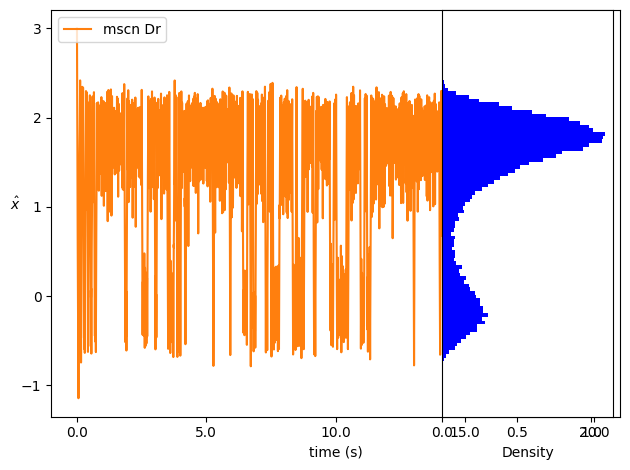

In [6]:


# Assuming mscn_x_hat and func are already defined in your workspace

# Create the main plot
fig, ax1 = plt.subplots()

# Plot mscn_x_hat time series data
ax1.plot(mscn_x_hat, color='tab:orange', label='mscn Dr')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('$\hat{x}$', rotation=0)
ax1.set_xticks(np.linspace(0, 20000, 5))
ax1.set_xticklabels(np.linspace(0, 20, 5))
ax1.legend(loc='upper left')

# Create an inset axis for the density plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax2 = inset_axes(ax1, width="30%", height="100%", loc='right', borderpad=0.5)

# Calculate and plot histogram on the inset axes
density, bins, _ = ax2.hist(mscn_x_hat, bins=100, density=True, orientation='horizontal', color='blue')
ax2.set_xlabel('Density')
ax2.set_ylim(ax1.get_ylim())  # Synchronize y-axis with the main plot

# Hide y-axis labels for density to avoid clutter
ax2.yaxis.set_visible(False)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


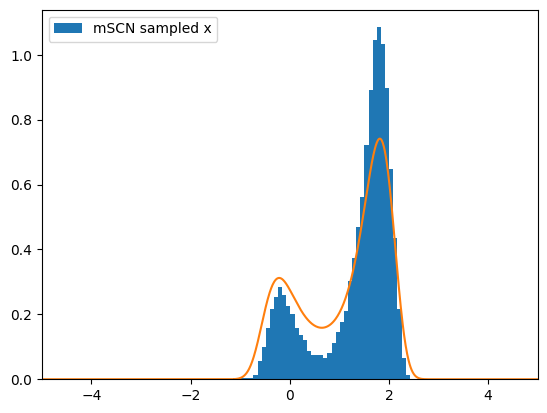

In [7]:
plt.hist(mscn_x_hat[:15000],density=True,bins=50, label = 'mSCN sampled x')
# plt.hist(x_hat,density=True,bins=100, alpha = 0.3, label = 'SCN sampled x')

x_vals = np.linspace(-5,5,1000)
# normalization constant
Z = np.sum(np.exp(-func(x_vals))/100)
# plot density
plt.plot(x_vals,np.exp(-func(x_vals))/Z)
plt.xlim(-5,5)
plt.legend()
plt.show()

# Panel D: subthreshold voltage correlation

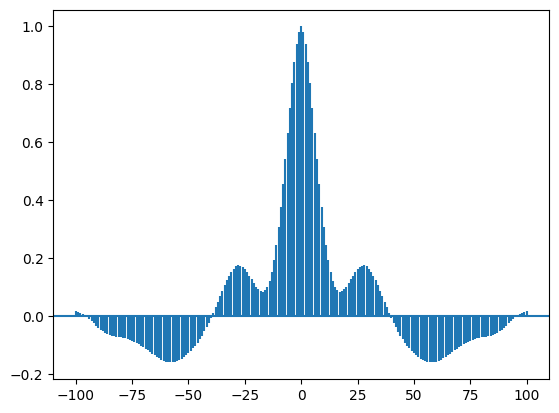

In [17]:
plt.xcorr(V[0],V[4],maxlags=100)
plt.show()

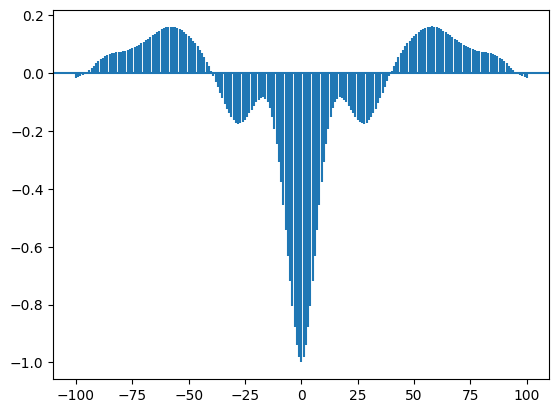

In [19]:
plt.xcorr(V[0],V[6],maxlags=100)
plt.show()